In [1]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN') # change folder name

Mounted at /content/drive


In [2]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *


In [3]:


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC18"

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2018_PAYMENT_APPLICATION_OUTCOME.CSV')
log_name = 'bpic_2017'




In [4]:

log_df = pd.read_csv(file_name)
log_df = log_df.reset_index(drop=True)


In [ ]:
log_df.head()

CASEID                  MILESTONE RESOURCE  TASK_DURATION  TIME_ELAPSED  \
0       2    Application_mail income    0;n/a              0             0   
1       2     Application_mail valid    0;n/a              0             0   
2       2     Application_initialize   019209            467             0   
3       2  Application_begin editing   019209              0           467   
4       2      Application_calculate   019209              0           467   

                 END_TIMESTAMP  ACTIVITY_INDEX  AMOUNT_REQ         OUTCOME  \
0  2015-05-15 08:00:00.0000000               1     7333.46  finish payment   
1  2015-05-15 08:00:00.0000000               2     7333.46  finish payment   
2  2016-08-24 16:48:22.4200000               3     7333.46  finish payment   
3  2016-08-24 16:48:31.3450000               4     7333.46  finish payment   
4  2016-08-24 16:48:44.3590000               5     7333.46  finish payment   

   TRACE_END  
0          0  
1          0  
2          0  
3          0  
4          0

#### How early should be the prediction

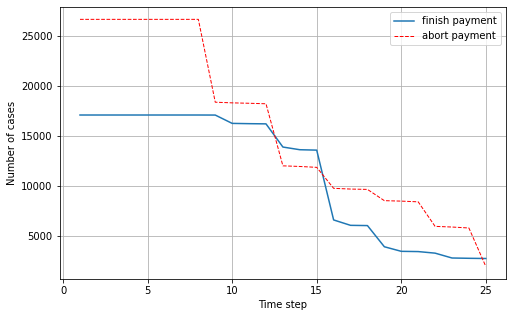

In [ ]:
# How predictable is the outcome as we move along the trace

df_t = log_df.groupby(['ACTIVITY_INDEX','OUTCOME'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'OUTCOME', values = 'CASEID').reset_index()
df_t = df_t.fillna(0)
df_t = df_t.iloc[:25]
x = df_t['ACTIVITY_INDEX']
y_0 = df_t['finish payment']
y_1 = df_t['abort payment']


plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, y_0 ,label = 'finish payment')
plt.plot(x, y_1, 
         color='red',   
         linewidth=1.0,  
         linestyle='--',
         label = 'abort payment' 
        )
plt.xlabel('Time step')
plt.ylabel('Number of cases')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
color_p = sn.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)


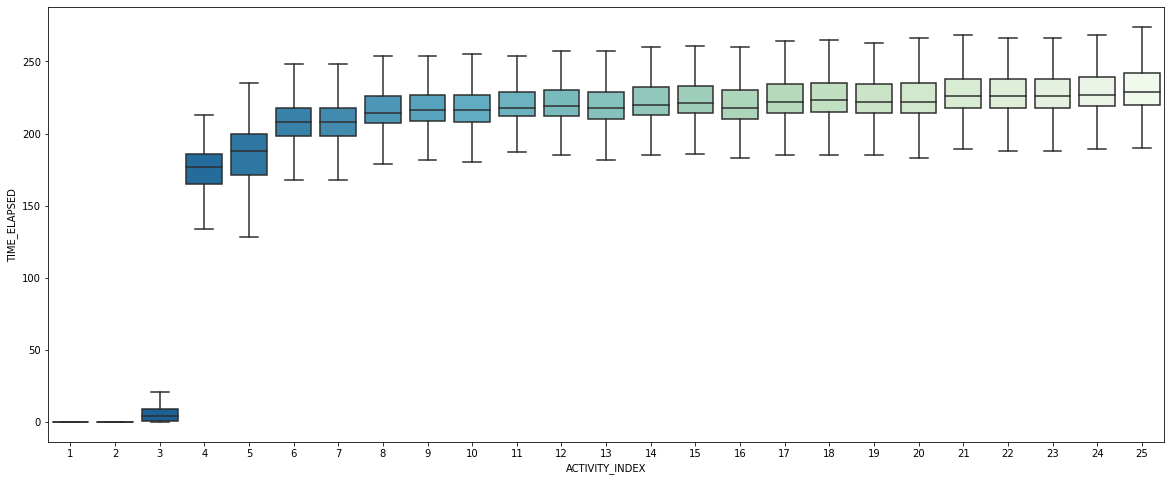

In [ ]:
# Distribution of the time spent on each case by the timestep

#bx = log_df.boxplot(column = 'TIME_ELAPSED', by = 'ACTIVITY_INDEX' )

plt.figure(figsize=(20,8))
df_t = log_df.loc[log_df['ACTIVITY_INDEX']<=50]
ax = sn.boxplot(x='ACTIVITY_INDEX', y='TIME_ELAPSED', palette='GnBu_r', data=df_t, showfliers = False)

In [ ]:
log_df['ACTIVITY'] = log_df['MILESTONE']

In [ ]:
#distribution of activity counts by the timestep
df_t = log_df.groupby(['CASEID','ACTIVITY'])['ACTIVITY_INDEX'].min().reset_index()
df_t = df_t.groupby(['ACTIVITY_INDEX','ACTIVITY'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'ACTIVITY', values = 'CASEID')
df_t = df_t.fillna(0)


In [ ]:
#activity order in average
df_act = log_df.groupby('ACTIVITY')['ACTIVITY_INDEX'].min().reset_index()
df_act = df_act.sort_values(by=['ACTIVITY_INDEX'])

In [ ]:
col = df_act['ACTIVITY'].to_list()

In [ ]:
col

['Application_initialize',
 'Application_mail income',
 'Application_mail valid',
 'Application_begin editing',
 'Main_change department',
 'Application_calculate',
 'Application_finish editing',
 'Application_insert document',
 'Main_insert document',
 'Main_save',
 'Main_take original document',
 'Application_decide',
 'Main_remove document',
 'Application_remove document',
 'Application_begin payment',
 'Application_revoke decision',
 'Application_abort payment',
 'Application_withdraw',
 'Application_finish payment',
 'Application_revoke withdrawal',
 'Objection_initialize',
 'Change_initialize',
 'Objection_begin admissibility check',
 'Change_begin editing',
 'Objection_calculate',
 'Objection_check admissibility',
 'Change_calculate',
 'Objection_insert document',
 'Change_finish editing',
 'Objection_approve',
 'Objection_refuse',
 'Objection_begin editing',
 'Change_decide',
 'Change_insert document',
 'Objection_finish editing',
 'Change_begin payment',
 'Objection_decide',
 

In [ ]:
col = ['Application_initialize',
 'Application_mail income',
 'Application_mail valid',
 'Application_begin editing',
 'Application_calculate',
 'Application_finish editing',
 'Application_insert document',
 'Main_insert document',
 'Main_save',
 'Application_decide',
 'Application_begin payment',
 'Application_revoke decision']

Text(114.0, 0.5, 'Time step')

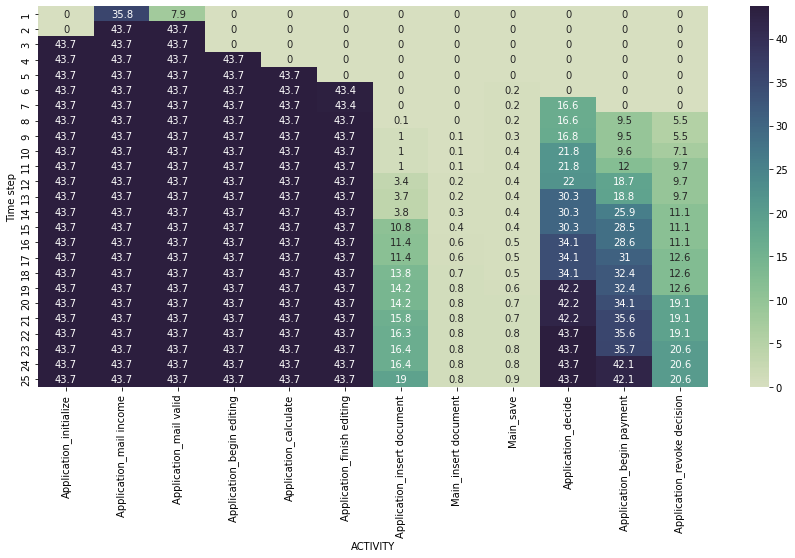

In [ ]:
df_a = df_t[col]
df_a = round(df_a.cumsum()/1000,1)
df_a = df_a.iloc[:25]
plt.figure(figsize=(15,7))
ax = sn.heatmap(df_a, cmap=color_p ,annot=True, fmt="g")
ax.set_ylabel('Time step')

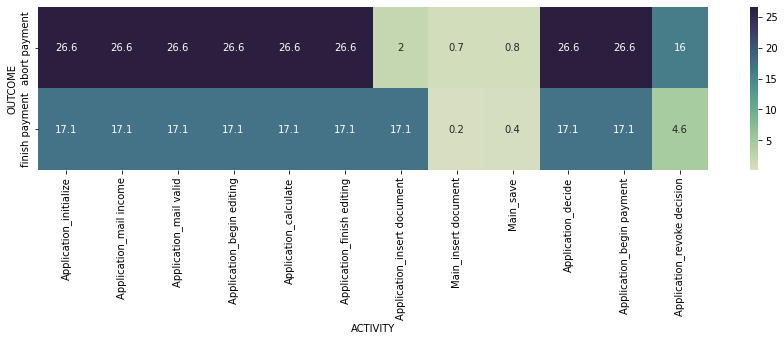

In [ ]:
#Outcome vs occurance of an activity in the trace

df_t1 = log_df.groupby(['ACTIVITY','OUTCOME'])['CASEID'].nunique().reset_index()

df_t1 = df_t1.pivot(index='OUTCOME',columns = 'ACTIVITY', values = 'CASEID') 
df_t1 = df_t1[col]
df_t1 = round(df_t1/1000,1)

plt.figure(figsize=(15,3))
ax = sn.heatmap(df_t1, cmap=color_p,annot=True, fmt="g")